<a href="https://colab.research.google.com/github/sejin-sim/Anomaly_Detection/blob/main/DAGMM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드 출처 : https://github.com/mperezcarrasco/PyTorch-DAGMM

In [1]:
pip install barbar

In [2]:
# utils.py

import torch

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)
        m.bias.data.fill_(0)

In [3]:
# forward_step.py

import torch
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np


class ComputeLoss:
    def __init__(self, model, lambda_energy, lambda_cov, device, n_gmm):
        self.model = model
        self.lambda_energy = lambda_energy
        self.lambda_cov = lambda_cov
        self.device = device
        self.n_gmm = n_gmm
    
    def forward(self, x, x_hat, z, gamma):
        """Computing the loss function for DAGMM."""
        reconst_loss = torch.mean((x-x_hat).pow(2))

        sample_energy, cov_diag = self.compute_energy(z, gamma)

        loss = reconst_loss + self.lambda_energy * sample_energy + self.lambda_cov * cov_diag
        return Variable(loss, requires_grad=True)
    
    def compute_energy(self, z, gamma, phi=None, mu=None, cov=None, sample_mean=True):
        """Computing the sample energy function"""
        if (phi is None) or (mu is None) or (cov is None):
            phi, mu, cov = self.compute_params(z, gamma)

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        eps = 1e-12
        cov_inverse = []
        det_cov = []
        cov_diag = 0
        for k in range(self.n_gmm):
            cov_k = cov[k] + (torch.eye(cov[k].size(-1))*eps).to(self.device)
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag += torch.sum(1 / cov_k.diag())
        
        cov_inverse = torch.cat(cov_inverse, dim=0)
        det_cov = torch.cat(det_cov).to(self.device)

        E_z = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        E_z = torch.exp(E_z)
        E_z = -torch.log(torch.sum(phi.unsqueeze(0)*E_z / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + eps)
        if sample_mean==True:
            E_z = torch.mean(E_z)            
        return E_z, cov_diag

    def compute_params(self, z, gamma):
        """Computing the parameters phi, mu and gamma for sample energy function """ 
        # K: number of Gaussian mixture components
        # N: Number of samples
        # D: Latent dimension
        # z = NxD
        # gamma = NxK

        #phi = D
        phi = torch.sum(gamma, dim=0)/gamma.size(0) 

        #mu = KxD
        mu = torch.sum(z.unsqueeze(1) * gamma.unsqueeze(-1), dim=0)
        mu /= torch.sum(gamma, dim=0).unsqueeze(-1)

        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))
        z_mu_z_mu_t = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        
        #cov = K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_z_mu_t, dim=0)
        cov /= torch.sum(gamma, dim=0).unsqueeze(-1).unsqueeze(-1)

        return phi, mu, cov
        

class Cholesky(torch.autograd.Function):
    def forward(ctx, a):
        l = torch.cholesky(a, False)
        ctx.save_for_backward(l)
        return l
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DAGMM(nn.Module):
    def __init__(self, n_gmm=2, z_dim=1):
        """Network for DAGMM (KDDCup99)"""
        super(DAGMM, self).__init__()
        #Encoder network
        self.fc1 = nn.Linear(118, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 10)
        self.fc4 = nn.Linear(10, z_dim)

        #Decoder network
        self.fc5 = nn.Linear(z_dim, 10)
        self.fc6 = nn.Linear(10, 30)
        self.fc7 = nn.Linear(30, 60)
        self.fc8 = nn.Linear(60, 118)

        #Estimation network
        self.fc9 = nn.Linear(z_dim+2, 10)
        self.fc10 = nn.Linear(10, n_gmm)

    def encode(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        h = torch.tanh(self.fc3(h))
        return self.fc4(h)

    def decode(self, x):
        h = torch.tanh(self.fc5(x))
        h = torch.tanh(self.fc6(h))
        h = torch.tanh(self.fc7(h))
        return self.fc8(h)
    
    def estimate(self, z):
        h = F.dropout(torch.tanh(self.fc9(z)), 0.5)
        return F.softmax(self.fc10(h), dim=1)
    
    def compute_reconstruction(self, x, x_hat):
        relative_euclidean_distance = (x-x_hat).norm(2, dim=1) / x.norm(2, dim=1)
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return relative_euclidean_distance, cosine_similarity
    
    def forward(self, x):
        z_c = self.encode(x)
        x_hat = self.decode(z_c)
        rec_1, rec_2 = self.compute_reconstruction(x, x_hat)
        z = torch.cat([z_c, rec_1.unsqueeze(-1), rec_2.unsqueeze(-1)], dim=1)
        gamma = self.estimate(z)
        return z_c, x_hat, z, gamma

In [5]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import pickle as pl



class KDDCupData:
    def __init__(self, data_dir, mode):
        """Loading the data for train and test."""
        data = np.load(data_dir, allow_pickle=True)

        labels = data["kdd"][:,-1]
        features = data["kdd"][:,:-1]
        #In this case, "atack" has been treated as normal data as is mentioned in the paper
        normal_data = features[labels==0] 
        normal_labels = labels[labels==0]

        n_train = int(normal_data.shape[0]*0.5)
        ixs = np.arange(normal_data.shape[0])
        np.random.shuffle(ixs)
        normal_data_test = normal_data[ixs[n_train:]]
        normal_labels_test = normal_labels[ixs[n_train:]]

        if mode == 'train':
            self.x = normal_data[ixs[:n_train]]
            self.y = normal_labels[ixs[:n_train]]
        elif mode == 'test':
            anomalous_data = features[labels==1]
            anomalous_labels = labels[labels==1]
            self.x = np.concatenate((anomalous_data, normal_data_test), axis=0)
            self.y = np.concatenate((anomalous_labels, normal_labels_test), axis=0)

    def __len__(self):
        """Number of images in the object dataset."""
        return self.x.shape[0]

    def __getitem__(self, index):
        """Return a sample from the dataset."""
        return np.float32(self.x[index]), np.float32(self.y[index])



def get_KDDCup99(args, data_dir='./data/kdd_cup.npz'):
    """Returning train and test dataloaders."""
    train = KDDCupData(data_dir, 'train')
    dataloader_train = DataLoader(train, batch_size=args.batch_size, 
                              shuffle=True, num_workers=0)
    
    test = KDDCupData(data_dir, 'test')
    dataloader_test = DataLoader(test, batch_size=args.batch_size, 
                              shuffle=False, num_workers=0)
    return dataloader_train, dataloader_test

In [6]:
import torch
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score


def eval(model, dataloaders, device, n_gmm):
    """Testing the DAGMM model"""
    dataloader_train, dataloader_test = dataloaders
    model.eval()
    print('Testing...')
    compute = ComputeLoss(model, None, None, device, n_gmm)
    with torch.no_grad():
        N_samples = 0
        gamma_sum = 0
        mu_sum = 0
        cov_sum = 0
        # Obtaining the parameters gamma, mu and cov using the trainin (clean) data.
        for x, _ in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            phi_batch, mu_batch, cov_batch = compute.compute_params(z, gamma)

            batch_gamma_sum = torch.sum(gamma, dim=0)
            gamma_sum += batch_gamma_sum
            mu_sum += mu_batch * batch_gamma_sum.unsqueeze(-1)
            cov_sum += cov_batch * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)
            
            N_samples += x.size(0)
            
        train_phi = gamma_sum / N_samples
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

        # Obtaining Labels and energy scores for train data
        energy_train = []
        labels_train = []
        for x, y in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, phi=train_phi,
                                                              mu=train_mu, cov=train_cov, 
                                                              sample_mean=False)
            
            energy_train.append(sample_energy.detach().cpu())
            labels_train.append(y)
        energy_train = torch.cat(energy_train).numpy()
        labels_train = torch.cat(labels_train).numpy()

        # Obtaining Labels and energy scores for test data
        energy_test = []
        labels_test = []
        for x, y in dataloader_test:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, train_phi,
                                                              train_mu, train_cov,
                                                              sample_mean=False)
            
            energy_test.append(sample_energy.detach().cpu())
            labels_test.append(y)
        energy_test = torch.cat(energy_test).numpy()
        labels_test = torch.cat(labels_test).numpy()
    
        scores_total = np.concatenate((energy_train, energy_test), axis=0)
        labels_total = np.concatenate((labels_train, labels_test), axis=0)

    threshold = np.percentile(scores_total, 100 - 20)
    pred = (energy_test > threshold).astype(int)
    gt = labels_test.astype(int)
    precision, recall, f_score, _ = prf(gt, pred, average='binary')
    print("Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(precision, recall, f_score))
    print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels_total, scores_total)*100))
    return labels_total, scores_total

In [7]:
import torch
from torch import optim
import torch.nn.functional as F

import numpy as np
from barbar import Bar

class TrainerDAGMM:
    """Trainer class for DAGMM."""
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader, self.test_loader = data
        self.device = device


    def train(self):
        """Training the DAGMM model"""
        self.model = DAGMM(self.args.n_gmm, self.args.latent_dim).to(self.device)
        self.model.apply(weights_init_normal)
        optimizer = optim.Adam(self.model.parameters(), lr=self.args.lr)

        self.compute = ComputeLoss(self.model, self.args.lambda_energy, self.args.lambda_cov, 
                                   self.device, self.args.n_gmm)
        self.model.train()
        for epoch in range(self.args.num_epochs):
            total_loss = 0
            for x, _ in Bar(self.train_loader):
                x = x.float().to(self.device)
                optimizer.zero_grad()
                
                _, x_hat, z, gamma = self.model(x)

                loss = self.compute.forward(x, x_hat, z, gamma)
                loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
                optimizer.step()

                total_loss += loss.item()
            print('Training DAGMM... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))

In [11]:
! git clone https://github.com/mperezcarrasco/PyTorch-DAGMM.git

Cloning into 'PyTorch-DAGMM'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 102 (delta 47), reused 61 (delta 20), pack-reused 0
Receiving objects: 100% (102/102), 1.83 MiB | 1.27 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [14]:
cp -r /content/PyTorch-DAGMM/data /content

In [15]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import pandas as pd 


class Args:
    num_epochs=200
    patience=50
    lr=1e-4
    lr_milestones=[50]
    batch_size=1024
    latent_dim=1
    n_gmm=4
    lambda_energy=0.1
    lambda_cov=0.005
    
    
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_KDDCup99(args)

dagmm = TrainerDAGMM(args, data, device)
dagmm.train()


198371/198371: [===============================>] - ETA 0.2s
Training DAGMM... Epoch: 0, Loss: 160208132.289
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 1, Loss: 160113942.227
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 2, Loss: 160075386.351
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 3, Loss: 159876415.464
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 4, Loss: 160131504.454
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 5, Loss: 160643000.454
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 6, Loss: 161017529.897
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 7, Loss: 159882099.175
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 8, Loss: 160184745.237
198371/198371: [===

In [16]:
labels, scores = eval(dagmm.model, data, device, args.n_gmm)

Testing...
Precision : 0.9523, Recall : 0.9228, F-score : 0.9373
ROC AUC score: 98.39


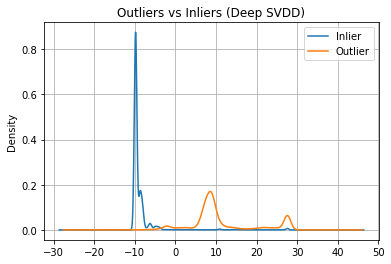

In [17]:
scores_in = scores[np.where(labels==0)[0]]
scores_out = scores[np.where(labels==1)[0]]


in_ = pd.DataFrame(scores_in, columns=['Inlier'])
out_ = pd.DataFrame(scores_out, columns=['Outlier'])


fig, ax = plt.subplots()
in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers (Deep SVDD)')
out_.plot.kde(ax=ax, legend=True)
ax.grid(axis='x')
ax.grid(axis='y')
plt.show()